### The main idea is trained a recurrent neural network with a Long - Short Term Memory layer to predict active energy based on reactive energy and current values

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df_train = pd.read_csv('Day1_data.csv')
df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.head()

,timestamp,active_energy,reactive_energy,rms_current_1,rms_current_2
0,2022-02-01 00:00:00,0.000054,0.000016,0.873489,1.664349
1,2022-02-01 00:00:01,0.000053,0.000016,0.864291,1.645654
2,2022-02-01 00:00:02,0.000053,0.000010,0.851083,1.656308
3,2022-02-01 00:00:03,0.000053,0.000011,0.860264,1.664380
4,2022-02-01 00:00:04,0.000054,0.000013,0.867394,1.669411


This is the data for one day of consume second to second in a household - this would be the train data set

In [8]:
df_train['timestamp'] = df_train['timestamp'].astype('datetime64[s]')
df_train.set_index('timestamp', inplace=True)

In [9]:
# Scaled the data to better performance
values = df_train.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.05837356, 0.18624189, 0.0292452 , 0.07899194],
       [0.05713892, 0.18576301, 0.02841823, 0.07772108],
       [0.05674591, 0.17138991, 0.02723077, 0.07844533],
       ...,
       [0.03460731, 0.1578158 , 0.02695709, 0.0226148 ],
       [0.03575048, 0.15886515, 0.02802468, 0.02357546],
       [0.03613268, 0.16450817, 0.02872257, 0.02320027]])

In [10]:
# Function to get the -1 position value in all variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('variable%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('variable%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('variable%d(t+%d)' % (j+1)) for j in range(n_vars)]

        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [11]:
reframed = series_to_supervised(scaled)
reframed

,variable1(t-1),variable2(t-1),variable3(t-1),variable4(t-1),variable1(t),variable2(t),variable3(t),variable4(t)
0,0.057139,0.185763,0.028418,0.077721,0.058374,0.186242,0.029245,0.078992
1,0.056746,0.171390,0.027231,0.078445,0.057139,0.185763,0.028418,0.077721
2,0.057310,0.173311,0.028056,0.078994,0.056746,0.171390,0.027231,0.078445
3,0.057718,0.177896,0.028697,0.079336,0.057310,0.173311,0.028056,0.078994
4,0.057589,0.180685,0.028026,0.079233,0.057718,0.177896,0.028697,0.079336
...,...,...,...,...,...,...,...,...
86379,0.035682,0.157795,0.028485,0.023375,0.034318,0.153100,0.026884,0.022861
86380,0.035145,0.157805,0.027721,0.022995,0.035682,0.157795,0.028485,0.023375
86381,0.034607,0.157816,0.026957,0.022615,0.035145,0.157805,0.027721,0.022995
86382,0.035750,0.158865,0.028025,0.023575,0.034607,0.157816,0.026957,0.022615


In [12]:
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
reframed

,variable1(t-1),variable2(t-1),variable3(t-1),variable4(t-1),variable1(t)
0,0.057139,0.185763,0.028418,0.077721,0.058374
1,0.056746,0.171390,0.027231,0.078445,0.057139
2,0.057310,0.173311,0.028056,0.078994,0.056746
3,0.057718,0.177896,0.028697,0.079336,0.057310
4,0.057589,0.180685,0.028026,0.079233,0.057718
...,...,...,...,...,...
86379,0.035682,0.157795,0.028485,0.023375,0.034318
86380,0.035145,0.157805,0.027721,0.022995,0.035682
86381,0.034607,0.157816,0.026957,0.022615,0.035145
86382,0.035750,0.158865,0.028025,0.023575,0.034607


We drop the independent variables because we want to predict the next variable in function the previous

In [13]:
train = reframed.values
train_x, train_y = train[:, :-1], train[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
train_x  # We train the neural network with this array, each deeper array is a second of consume values of energy

array([[[0.05713892, 0.18576301, 0.02841823, 0.07772108]],

       [[0.05674591, 0.17138991, 0.02723077, 0.07844533]],

       [[0.05730997, 0.17331063, 0.02805614, 0.07899402]],

       ...,

       [[0.03460731, 0.1578158 , 0.02695709, 0.0226148 ]],

       [[0.03575048, 0.15886515, 0.02802468, 0.02357546]],

       [[0.03613268, 0.16450817, 0.02872257, 0.02320027]]])

In [14]:
df_test = pd.read_csv('Day2_data.csv')
df_test['timestamp'] = df_test['timestamp'].astype('datetime64[s]')
df_test.set_index('timestamp', inplace=True)
df_test.head()

,active_energy,reactive_energy,rms_current_1,rms_current_2
timestamp,,,,
2022-02-06 00:00:00,0.000142,0.000028,1.171571,3.779301
2022-02-06 00:00:01,0.000142,0.000029,1.174427,3.779238
2022-02-06 00:00:02,0.000143,0.000029,1.177282,3.779174
2022-02-06 00:00:03,0.000143,0.000016,1.187354,3.775317
2022-02-06 00:00:04,0.000141,0.000026,1.177385,3.758446


This is the next day of consume in the same house - this would be the test data set

In [15]:
values_test = df_test.values
scaled_test = scaler.fit_transform(values_test)
reframed_test = series_to_supervised(scaled_test, 1, 1)
reframed_test.drop(reframed_test.columns[[5,6,7]], axis=1, inplace=True)
reframed_test

,variable1(t-1),variable2(t-1),variable3(t-1),variable4(t-1),variable1(t)
0,0.298696,0.130524,0.050658,0.248447,0.297607
1,0.299785,0.131578,0.050890,0.248443,0.298696
2,0.299261,0.070923,0.051710,0.248151,0.299785
3,0.295753,0.120011,0.050899,0.246874,0.299261
4,0.299041,0.120934,0.051279,0.247807,0.295753
...,...,...,...,...,...
83727,0.038818,0.024249,0.017960,0.027522,0.040405
83728,0.039694,0.026419,0.019757,0.027442,0.038818
83729,0.040504,0.026145,0.019598,0.027953,0.039694
83730,0.037910,0.023595,0.017337,0.027221,0.040504


In [16]:
test = reframed_test.values
test_x, test_y = test[:, :-1], test[:, -1]
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [17]:
# Build the recurrent neural network
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
# Train the model
history = model.fit(train_x, train_y, epochs=20, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/20
1235/1235 - 12s - loss: 8.8258e-04 - val_loss: 0.0085 - 12s/epoch - 10ms/step
Epoch 2/20
1235/1235 - 12s - loss: 4.2514e-04 - val_loss: 0.0030 - 12s/epoch - 10ms/step
Epoch 3/20
1235/1235 - 9s - loss: 2.2264e-04 - val_loss: 0.0016 - 9s/epoch - 8ms/step
Epoch 4/20
1235/1235 - 8s - loss: 1.7808e-04 - val_loss: 0.0012 - 8s/epoch - 6ms/step
Epoch 5/20
1235/1235 - 7s - loss: 1.6815e-04 - val_loss: 8.4049e-04 - 7s/epoch - 6ms/step
Epoch 6/20
1235/1235 - 7s - loss: 1.5596e-04 - val_loss: 8.3171e-04 - 7s/epoch - 6ms/step
Epoch 7/20
1235/1235 - 6s - loss: 1.5111e-04 - val_loss: 7.3574e-04 - 6s/epoch - 5ms/step
Epoch 8/20
1235/1235 - 6s - loss: 1.4518e-04 - val_loss: 6.2806e-04 - 6s/epoch - 4ms/step
Epoch 9/20
1235/1235 - 6s - loss: 1.4194e-04 - val_loss: 5.8198e-04 - 6s/epoch - 5ms/step
Epoch 10/20
1235/1235 - 6s - loss: 1.3640e-04 - val_loss: 5.2923e-04 - 6s/epoch - 5ms/step
Epoch 11/20
1235/1235 - 6s - loss: 1.2488e-04 - val_loss: 4.6418e-04 - 6s/epoch - 5ms/step
Epoch 12/20
1235/1

In [ ]:
loss = pd.DataFrame(history.history)

<AxesSubplot:>

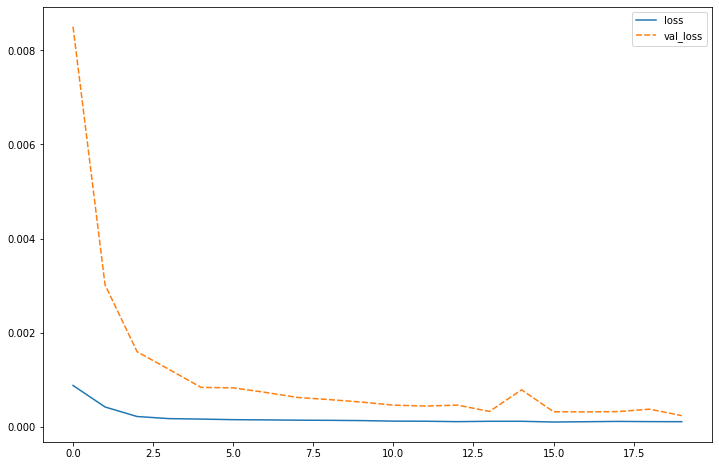

In [33]:
plt.figure(figsize=(12,8))
sns.lineplot(data=loss)

In [20]:
# Make predictions
predict = model.predict(test_x)

In [21]:
predict_shape_1 = predict.reshape(predict.shape[0])

In [22]:
# Predictions in scalar format
scaler_predict = pd.DataFrame(data=[predict_shape_1, test_y]).T
scaler_predict.columns = ['predict', 'actual']
scaler_predict

,predict,actual
0,0.293284,0.297607
1,0.294140,0.298696
2,0.298294,0.299785
3,0.291408,0.299261
4,0.294262,0.295753
...,...,...
83727,0.049973,0.040405
83728,0.050641,0.038818
83729,0.051401,0.039694
83730,0.049183,0.040504


<AxesSubplot:>

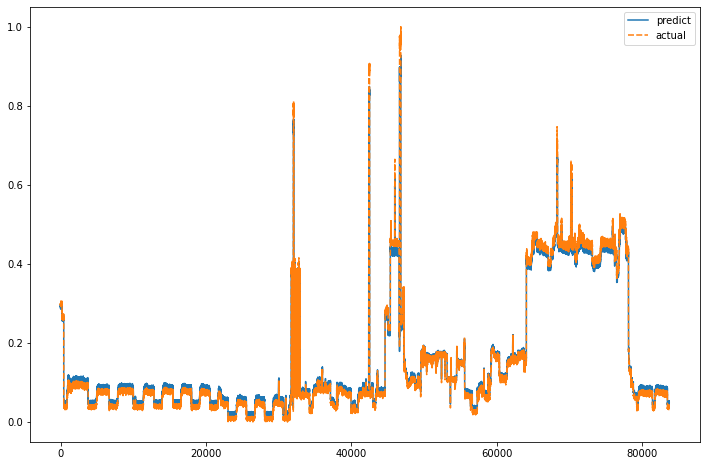

In [34]:
plt.figure(figsize=(12,8))
sns.lineplot(data=scaler_predict)

In [24]:
rmse = np.sqrt(mean_squared_error(predict, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.016


In [25]:
test_x = test_x.reshape((test_x.shape[0], 4))

In [26]:
# Reconvert the scalar format
predict_real = np.concatenate((predict, test_x[:, -3:]), axis=1)
predict_real = scaler.inverse_transform(predict_real)
predict_real = predict_real[:,0]

In [27]:
energy_predict = pd.DataFrame(data=[predict_real, df_test.active_energy]).T
energy_predict.columns = ['predict', 'actual']

<AxesSubplot:>

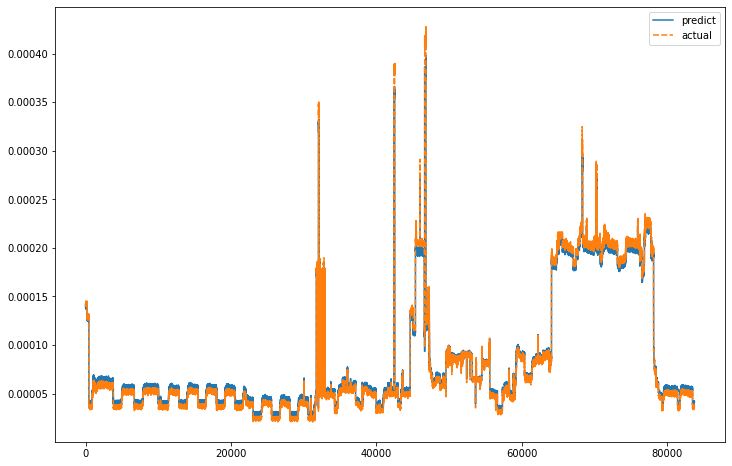

In [35]:
plt.figure(figsize=(12,8))
sns.lineplot(data=energy_predict)